<a href="https://colab.research.google.com/github/vid-Math/DeepLearning/blob/main/DNN_boilerplate_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from keras.layers import Dense, Flatten
from keras import Input
from tensorflow.keras.utils import plot_model

from tensorflow.keras.datasets import mnist, fashion_mnist

# Basic Sequential Model

Sequential Model - layers of neural network are stacked sequentially. The approach:
1.  Implement a class to build a dense layer (NaiveDense)
2.  Stack the layers sequentially and build or suquential model (NaiveSequential)


In [1]:
# Implemnting dense layer class
class NaiveDense:
  def __init__(self, input_size, output_size, activation):  #input and output sizes for the layer
    self.activation = activation

    w_shape = (input_size, output_size)       # matrix of weights
    w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
    self.w = tf.Variable(w_initial_value)     # we can only update values of tf.Variables

    b_shape = (output_size,)                  # vector of biases
    b_initial_value = tf.zeros(b_shape)
    self.b = tf.Variable(b_initial_value)

  def __call__(self, inputs):                 # executed when the class object is used as a function
    return self.activation(tf.matmul(inputs, self.w)+self.b)      # self.b is broadcasted

  @property                                   # enables us to use the method as an attribute
  def weights(self):
    return (self.w, self.b)

Now stacking them together sequentially in NaiveSequential class

In [2]:
class NaiveSequential:
  def __init__(self,layers):    # layers: list of layer objects
    self.layers = layers

  def __call__(self, inputs):   
    x = inputs
    for layer in self.layers:     #ouptut of the prev layer is the input to the next layer
      x = layer(x)
    return x

  @property
  def weights(self):
    weights = []
    for layer in self.layers:     # save weights of each layer to a list
      weights += layer.weights    # Q: What does layer.weights return? 
    return weights                # A: layer.weights calls the function layer.weights() since it decorated with @property. It returns (w,b)



Iinstantiate our NaiveSequential class and make first NN model

In [5]:
# define the model
# input to the model - layers (NaiveDense)
model = NaiveSequential([
        NaiveDense(input_size=28*28,output_size=512,activation=tf.nn.relu), #input dim = 28*24 = 784
        NaiveDense(input_size=512,output_size=10,activation=tf.nn.softmax)  #output dim = 10 
])

Let's solve a calssification problem by using above sequential model for [MNIST data set](https://keras.io/api/datasets/mnist/). 

Steps followed:
1. Load the data, 
2. Reshape the data according to the input shape of the model and 
3. Normalize the data

11490434/11490434 [==============================] - 0s 0us/step
train_images.shape = (60000, 28, 28)
train_labels.shape = (60000,)
label for image id 7:  3


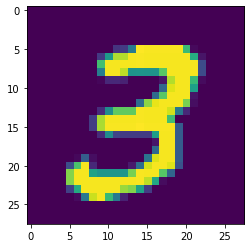

In [6]:
# Load data
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
print(f"train_images.shape = {train_images.shape}")
print(f"train_labels.shape = {train_labels.shape}")

idx = 7
plt.imshow(train_images[idx])
print(f"label for image id {idx}: ",train_labels[idx])


In [7]:
# reshape and normalize data
train_images = train_images.reshape((len(train_images),
                                     28*28)).astype("float32")/255
test_images = test_images.reshape((len(test_images),
                                     28*28)).astype("float32")/255

print(train_labels)

[5 0 4 ... 5 6 8]


Next we divide the data into batches. For this operation let's implement a class for Batch Generation.

In [8]:
class BatchGenerator:

  def __init__(self, images, labels, batch_size=128):
    assert len(images) == len(labels)
    self.index = 0
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.num_batches = math.ceil(len(images)/batch_size)
    print(f"batch size = {batch_size}")
    print(f"num of batches = {self.num_batches}")

  def next(self):
    images = self.images[self.index:self.index + self.batch_size]
    labels = self.labels[self.index:self.index + self.batch_size]
    self.index += self.batch_size
    return images, labels


*Training steps:*

1. Compute the predictions using current weights (Forward Pass).
2. Compute the loss value for these predictions.
3. Compute the gradient with respect to model weights.
4. update the weights.

In [1]:
# one_training_step function gives the idea of how loss is computed and layer \
# parameters (weights and biases) are updated
def one_training_step(model, images_batch, labels_batch):
  with tf.GradientTape() as tape:                   # GradientTape() is the computational graph 
    predictions = model(images_batch)               # forward pass.  - step1
    per_sample_losses = keras.losses.sparse_categorical_crossentropy(  # define loss - step2
        labels_batch, predictions
    )
    average_loss = tf.reduce_mean(per_sample_losses)  
  gradients = tape.gradient(average_loss, model.weights)      # Compute gradients - step 3
  update_weights(gradients, model.weights)                    # Update the weights - step 4 learning is happening
  return average_loss

learning_rate = 1e-3
def update_weights(gradients, weights):
  for g,w in zip(gradients, weights):
    w.assign_sub(g*learning_rate)             # w -= g*lr
    
# Full training loop
# one loop for mini batch and then for another batch
def fit(model, images, labels, epochs, batch_size=128):
  for epoch in range(epochs):                       # repeat for epochs
    print(f"Epoch {epoch}")
    batch_generator = BatchGenerator(images, labels)
    for batch_counter in range(batch_generator.num_batches):      # go through all mini-batches in the data
      images_batch, labels_batch = batch_generator.next()
      loss = one_training_step(model, images_batch, labels_batch)
      if batch_counter%100 == 0:
        print(f"loss at batch {batch_counter}:{loss:.2f}")


Now let's train the model on MNIST data set.

In [ ]:
fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
batch size = 128
num of batches = 469
loss at batch 0:6.04
loss at batch 100:2.23
loss at batch 200:2.19
loss at batch 300:2.09
loss at batch 400:2.24
Epoch 1
batch size = 128
num of batches = 469
loss at batch 0:1.93
loss at batch 100:1.88
loss at batch 200:1.82
loss at batch 300:1.73
loss at batch 400:1.85
Epoch 2
batch size = 128
num of batches = 469
loss at batch 0:1.61
loss at batch 100:1.58
loss at batch 200:1.49
loss at batch 300:1.44
loss at batch 400:1.52
Epoch 3
batch size = 128
num of batches = 469
loss at batch 0:1.35
loss at batch 100:1.34
loss at batch 200:1.22
loss at batch 300:1.22
loss at batch 400:1.27
Epoch 4
batch size = 128
num of batches = 469
loss at batch 0:1.14
loss at batch 100:1.15
loss at batch 200:1.03
loss at batch 300:1.05
loss at batch 400:1.10
Epoch 5
batch size = 128
num of batches = 469
loss at batch 0:0.99
loss at batch 100:1.01
loss at batch 200:0.89
loss at batch 300:0.93
loss at batch 400:0.98
Epoch 6
batch size = 128
num of batches = 469


In [ ]:
#  Evaluation step
predictions = model(test_images).numpy()
predicted_labels = np.argmax(predictions,axis=1) 
matches = predicted_labels == test_labels
print(f"accuracy:{matches.mean():.2f}")
print(predictions.shape)
print(predicted_labels)
print(matches)



accuracy:0.81
(10000, 10)
[7 3 1 ... 4 8 6]
[ True False  True ...  True False  True]


7 7


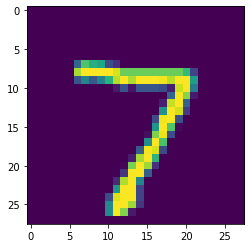

In [ ]:
idx = 0
plt.imshow(test_images[idx].reshape(28,28))
print(predicted_labels[idx], test_labels[idx])